In [1]:
import pandas as pd 
import numpy as np 
import gc 
import lightgbm as lgb

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline

load basic features 

In [3]:
%%time 
df_train = pd.read_pickle('../input/feats/df_trn_feat0.pkl')
# df_test = pd.read_pickle('../input/feats/df_test_feat0.pkl')

Wall time: 130 ms


In [4]:
df_train['price_log1'] = df_train.price.apply(np.log1p)

load text features

In [5]:
%%time 
with pd.HDFStore('../input/feats/txt_td_tfidf_hash5.h5') as store:
    print(store.keys())
    df_trn_text_feat  = store['df_trn_text_feat']
    df_test_text_feat = store['df_test_text_feat']

['/df_test_text_feat', '/df_trn_text_feat']
Wall time: 320 ms


load fm features 

In [5]:
# %%time 
# with pd.HDFStore('../input/feats/fm_uidx_rc_cnt_lat2.h5') as store:
#     print(store.keys())
#     df_fm_uidx_rc_cnt_lat2 = store['fm_uidx_rc_cnt_lat2']

In [12]:
# df_fm_uidx_rc_cnt_lat2.head().T

In [5]:
# df_train = df_train.merge(df_fm_uidx_rc_cnt_lat2,how='left',on=['uidx','region_city_label'])
# df_test = df_test.merge(df_fm_uidx_rc_cnt_lat2,how='left',on=['uidx','region_city_label'])

In [24]:
# df_train['cnt_by_uidx_rc'] = df_train['cnt'].astype('float16')
# df_train.drop('cnt',axis=1,inplace=True)

load interaction tsvd features

In [6]:
# %%time 
# with pd.HDFStore('../input/feats/feat2_trn_inter_svd.h5') as store:
#     print(store.keys())
#     df_trn_inter_svd = store['df_trn_inter_svd']
#     df_test_inter_svd = store['df_test_inter_svd']

load zero prediction

In [30]:
%%time 
cut_off = 0.8
meta_zero_pred = np.load('../input/feats/meta_zero_deal.npy')
df_zero_pred = pd.DataFrame({'pred_zero':meta_zero_pred})

df_zero_pred['pred_zero'] = df_zero_pred.pred_zero > cut_off

Wall time: 11 ms


cnt by uidx param1

In [4]:
# df_cnt_uidx_param1 = df_train.groupby(['uidx','param_1']).size().astype('uint16').reset_index().rename(columns={0:'cnt_by_uidx_param1'})
# df_train = df_train.merge(df_cnt_uidx_param1,how='left',on=['uidx','param_1'])
# df_train['cnt_by_uidx_param1'] = df_train.cnt_by_uidx_param1.fillna(0).astype('uint16')

cnt by uidx category name

In [10]:
# df_cnt_uidx_cat = df_train.groupby(['uidx','category_name']).size().astype('uint16').reset_index().rename(columns={0:'cnt_by_uidx_cat'})
# df_train = df_train.merge(df_cnt_uidx_cat,how='left',on=['uidx','category_name'])
# df_train['cnt_by_uidx_cat'] = df_train.cnt_by_uidx_cat.fillna(0).astype('uint16')

In [7]:
# df_train.cnt_by_uidx_cat.head()

combine features

In [33]:
%%time
# df_train = pd.concat([df_train, df_trn_text_feat ],axis=1)
# df_train = pd.concat([df_train,df_trn_text_feat,df_trn_inter_svd], axis=1)
df_train = pd.concat([df_train, df_zero_pred],axis=1)

Wall time: 86.1 ms


In [34]:
selcols = list(df_train.columns)
drop_cols = ['deal_probability','activation_date','iid','price']
#              'param_2','param_3']
# drop_cols += ['title_tfidf_{}'.format(e) for e in range(2,5)] + \
#             ['title_hash_{}'.format(e) for e in [0]] +\
#             ['desc_tfidf_{}'.format(e) for e in [1,4]] + \
#             ['desc_hash_{}'.format(e) for e in [1,3,4]] 

selcols = [col for col in selcols if col not in drop_cols]


categorical = ['month','day','weekday',
               'param_1',
               'param_2','param_3',
               'category_name','parent_category_name',
               'region_city_label', 'pred_zero',
               'user_type']

X_train = df_train[selcols].copy()
y_train = df_train['deal_probability']



In [35]:
df_train[selcols+['deal_probability']].corr().deal_probability

uidx                 0.138035
iidx                -0.060865
region_city_label    0.004327
tit_len              0.016143
desc_len            -0.000968
month                0.003555
day                 -0.002379
weekday              0.002096
image_top_1          0.189979
ads_cnt_by_uid      -0.062903
ads_cnt_by_iid       0.121960
price_log1           0.045754
pred_zero           -0.312128
deal_probability     1.000000
Name: deal_probability, dtype: float64

In [36]:
print('shape of X_train:',X_train.shape)

shape of X_train: (1503424, 19)


In [37]:
X_train.columns

Index(['uidx', 'iidx', 'region_city_label', 'tit_len', 'desc_len', 'month',
       'day', 'weekday', 'param_1', 'param_2', 'param_3', 'user_type',
       'parent_category_name', 'category_name', 'image_top_1',
       'ads_cnt_by_uid', 'ads_cnt_by_iid', 'price_log1', 'pred_zero'],
      dtype='object')

##### KFold

use built-in `lgb.cv`

In [39]:
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',    
    'max_depth': -1,
    'num_leaves': 33,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    'learning_rate': 0.1
}  

predictors = list(X_train.columns)



dtrain = lgb.Dataset(X_train, label=y_train, feature_name=predictors, categorical_feature=categorical)
cv_results = lgb.cv(lgbm_params, dtrain, 
                    num_boost_round=10000, 
                    nfold=4,
                    stratified=False,
                    early_stopping_rounds=10,
                    verbose_eval= 100)
print('done')

C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	cv_agg's rmse: 0.227517 + 0.000287054
[200]	cv_agg's rmse: 0.22658 + 0.000239953
[300]	cv_agg's rmse: 0.226181 + 0.00026135
[400]	cv_agg's rmse: 0.225916 + 0.000279732
[500]	cv_agg's rmse: 0.225735 + 0.000304168
[600]	cv_agg's rmse: 0.225648 + 0.000308691
[700]	cv_agg's rmse: 0.225566 + 0.000314014
done


____

In [31]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [58]:
kf.n_splits

4

In [49]:
NFOLDS = 4
kf = KFold(n_splits=NFOLDS,random_state=0)
rmse_results = []
# def oof:
for nfold,(trn_idx, val_idx) in enumerate(kf.split(X_train)):
    x_trn, y_trn = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
    x_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    dtrain = lgb.Dataset(x_trn,y_trn, feature_name=predictors, categorical_feature=categorical)
    dval   = lgb.Dataset(x_val,y_val, feature_name=predictors, categorical_feature=categorical)
    
    lgb_clf = lgb.train(lgbm_params,num_boost_round = 10000,
                        train_set = dtrain,
                        valid_sets = [dtrain, dval] ,                        
                        early_stopping_rounds=10,
                        verbose_eval= 0)                    
    y_pred = lgb_clf.predict(x_val)
    rmse = (mean_squared_error(y_pred,y_val))**0.5
    print('fold:{},\trmse:\t{:.4f}'.format(nfold,rmse))
    rmse_results.append(rmse)
print('mean rmse : \t{:.4f}'.format(np.mean(rmse_results) ))

C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


fold:0,	rmse:	0.2240
fold:1,	rmse:	0.2240
fold:2,	rmse:	0.2235
fold:3,	rmse:	0.2244


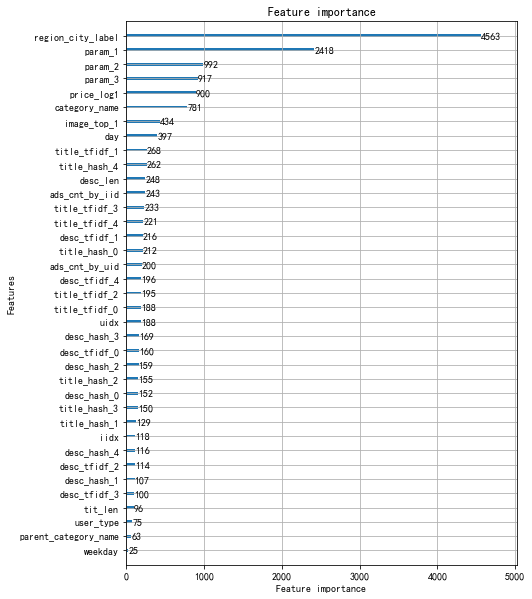

In [51]:
# feat_names = lgb_clf.feature_name()
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf,max_num_features=50, ax=ax)
# pd.DataFrame({'feat_idx':range(len(feat_names))})

In [40]:
feat_imp = pd.DataFrame({'f':lgb_clf.feature_name(),
                         'split':lgb_clf.feature_importance(importance_type='split'),
                         'gain':lgb_clf.feature_importance(importance_type='gain')}).sort_values(by='split',ascending=False)

In [43]:
feat_imp.head(20)

,f,gain,split
2,region_city_label,15100.792241,5988
8,param_1,35224.964765,3267
9,param_2,8581.022626,1205
10,param_3,3694.306379,1203
17,price_log1,5572.762249,1196
13,category_name,26133.717461,972
6,day,776.373718,828
14,image_top_1,3572.760681,659
16,ads_cnt_by_iid,2079.301587,414
27,title_hash_4,1430.029037,400


In [42]:
feat_imp.sort_values(by='gain',ascending=False).head(20)

,f,gain,split
8,param_1,35224.964765,3267
13,category_name,26133.717461,972
2,region_city_label,15100.792241,5988
9,param_2,8581.022626,1205
17,price_log1,5572.762249,1196
15,ads_cnt_by_uid,4348.241808,322
10,param_3,3694.306379,1203
14,image_top_1,3572.760681,659
16,ads_cnt_by_iid,2079.301587,414
27,title_hash_4,1430.029037,400


____

In [54]:
df_train.head()

,uidx,iidx,iid,region_city_label,tit_len,desc_len,activation_date,month,day,weekday,...,desc_tfidf_0,desc_tfidf_1,desc_tfidf_2,desc_tfidf_3,desc_tfidf_4,desc_hash_0,desc_hash_1,desc_hash_2,desc_hash_3,desc_hash_4
0,0,0,0,378,3,7,2017-03-28,3,28,1,...,1.505374e-07,0.008898,0.004794,0.016728,-0.013758,0.000001,0.051250,-0.031008,0.027714,0.004058
1,1,1,1,454,3,7,2017-03-26,3,26,6,...,6.169196e-08,0.001450,0.000644,0.002841,-0.002896,0.000001,0.055052,-0.038306,0.024452,0.002072
2,2,2,2,930,2,17,2017-03-20,3,20,0,...,2.690877e-07,0.163068,-0.102873,-0.002684,0.003413,0.000002,0.203219,0.212567,-0.014307,-0.169487
3,3,3,3,319,1,3,2017-03-25,3,25,5,...,2.309691e-07,0.025086,0.008745,0.047072,-0.059101,0.000001,0.110025,-0.029761,0.172299,0.006020
4,4,4,4,977,3,4,2017-03-16,3,16,3,...,1.658187e-07,0.032382,0.005093,0.052635,-0.066682,0.000003,0.143173,-0.095125,0.056822,-0.016192
